# Lecture outline

1. Resources for learning Python
1. Experimental framework implementation
1. Performance evaluation
1. Assignments

# 1. Resources for learning Python, numpy, pandas and Jupyter notebooks

**Read this guide/tutorial first**: [Running Jupyter Notebooks With The Anaconda Python Distribution](https://www.datacamp.com/community/tutorials/tutorial-jupyter-notebook) and please note that:
* You can skip parts on pip & docker. 
* Install Anaconda (with Python 3) only.
* Do not hesitate to follow links included in the guide.

**Then**, consider proceeding to:

1. [Intro to Python for Data Science](https://www.datacamp.com/courses/intro-to-python-for-data-science) - I do not have personal experience with this course, but since it was referenced in the DataCamp guide, it should be OK (and free)
1. [Python Data Science Cookbook](https://www.packtpub.com/big-data-and-business-intelligence/python-data-science-cookbook) - book I can highly recommend
1. [Python for Data Science and Machine Learning Bootcamp](https://www.udemy.com/python-for-data-science-and-machine-learning-bootcamp/) - Good Udemy course with examples in Jupyter notebooks (often in sale for ca. $10)
1. Last, but not least, use *Google*. Feel free to type in name of module you are interested in and you will find lots of helpful resources. Official documentation sites (e.g. for [NumPy](https://docs.scipy.org/doc/numpy/reference/)) are great places to start as well.

**Good luck!**

Little bit of motivation:

<img src="img/matlab_vs_python.png">

Source: [Google Trends](https://trends.google.com/trends/explore?q=%2Fm%2F053_x,Python)

Disclaimer: _I am very happy user of MATLAB, as well_ :-)

# 2. Experimental framework implementation

## Best practice to implement and test $n$ heuristics and $m$ objective functions?

* There are some common characteristics for the two most important _things_ in our framework
  * Heuristics - store best found solution, manage stop criterion, etc.
  * Objective functions - store $f^*$, lower/upper bounds, etc.
* Every specific heuristic or obj. function implements its own search space exploration or evaluation, neighbourhood generation, etc.
* Thus, object-oriented design should help us to separate this concerns as much as possible and also to keep us sane.

<img src="img/oop_design.png">

## Example: two objective functions and generalized Shoot&Go


### Objective functions

#### 1. AirShip

* Same as on the previous class, but we will **minimize** obj. function values
* implemented as ``class AirShip(ObjFun)`` in ``src/objfun_airship.py``

In [1]:
# Import path to source directory (bit of a hack in Jupyter)
import sys
import os
pwd = %pwd
sys.path.append(os.path.join(pwd, os.path.join('..', 'src')))

# Ensure modules are reloaded on any change (very useful when developing code on the fly)
%load_ext autoreload
%autoreload 2

In [2]:
from objfun_airship import AirShip
airship = AirShip()

In [3]:
airship.get_bounds()

[0, 799]

In [4]:
airship.get_fstar()

-100

In [5]:
airship.generate_point()

252

In [6]:
airship.evaluate(50)

-100.0

#### 2. $\sum \mathbf{x}$

* Just as demonstration of vectorized lower/upper bounds
* implemented as ``class Sum(ObjFun)`` in ``src/objfun_sum.py``

In [7]:
from objfun_sum import Sum
of_sum = Sum([0, 0, 0, 0], [10, 10, 10, 10])

In [8]:
x = of_sum.generate_point()
print(x)
print(of_sum.evaluate(x))

[9, 9, 3, 0]
21


In [9]:
print(of_sum.get_neighborhood(x, 1))

[[8, 9, 3, 0], [10, 9, 3, 0], [9, 8, 3, 0], [9, 10, 3, 0], [9, 9, 2, 0], [9, 9, 4, 0], [9, 9, 3, 1]]


In [10]:
print(of_sum.get_neighborhood(x, 2))

AssertionError: Sum(x) supports neighbourhood with diameter = 1 only

^^ This behaviour is intended. See code for details.

In [11]:
of_sum.get_neighborhood([0, 0, 0, 0], 1)

[[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]

### Generalized Shoot&Go: $\mathrm{SG}_{hmax}$

* Shoot & Go heuristic (also known as *Iterated Local Search*, *Random-restart hill climbing*, etc)
    * $hmax \in \{ 0, 1, \ldots, \infty \}$ parameter - maximum number of local searches / hill climbs
    * note that $\mathrm{SG}_{0}$ is pure Random Shooting (Random Search)
    
* implemented as ``class ShootAndGo(Heuristic)`` in ``src/heur_sg.py``    



In [12]:
from heur_sg import ShootAndGo

In [13]:
# Random Shooting for the AirShip initialization...
demo_rs = ShootAndGo(airship, maxeval=100, hmax=0)
# ...and execution:
demo_rs.search()

{'best_x': 46, 'best_y': -92.0, 'log_data': Empty DataFrame
 Columns: []
 Index: [], 'neval': inf}

# 2. Performance evaluation

## What is the recommended approach to store and analyze results of your experiments?

1. Append all relevant statistics from a single run into table (e.g. CSV file in memory or on disk), including all task and heuristic parameters 
2. Load the table into analytical tool of your choice (**data frame**, Excel or Google Docs spreadsheets, etc.)
3. Pivot by relevant parameters, visualize in tables or charts

## Demonstration

Neccessary setup first:

In [14]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook

### General experiment setup

Runs selected objective function (`of`) using selected heuristic multiple times, stores and returns data (results) in a data frame.

In [15]:
def experiment(of, num_runs, hmax):
    results = []
    for i in tqdm_notebook(range(num_runs), 'Testing hmax = {}'.format(hmax)):
        result = ShootAndGo(of, maxeval=100, hmax=hmax).search() # dict with results of one run
        result['run'] = i
        result['heur'] = 'SG_{}'.format(hmax) # name of the heuristic
        result['hmax'] = hmax
        results.append(result)
    return pd.DataFrame(results, columns=['heur', 'run', 'hmax', 'best_x', 'best_y', 'neval'])

### Air Ship experiments

In [16]:
table = pd.DataFrame()
for hmax in [0, 1, 2, 5, 10, 20, 50, np.inf]:
    res = experiment(airship, 10000, hmax)
    table = pd.concat([table, res], axis=0)

**Note**: This is what you should see while experiments are in progress:

<img src="img/tqdm_progress.png">

In [17]:
table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80000 entries, 0 to 9999
Data columns (total 6 columns):
heur      80000 non-null object
run       80000 non-null int64
hmax      80000 non-null float64
best_x    80000 non-null int64
best_y    80000 non-null float64
neval     80000 non-null float64
dtypes: float64(3), int64(2), object(1)
memory usage: 4.3+ MB


In [18]:
table.head()

,heur,run,hmax,best_x,best_y,neval
0,SG_0,0,0.0,59,-82.0,inf
1,SG_0,1,0.0,49,-98.0,inf
2,SG_0,2,0.0,46,-92.0,inf
3,SG_0,3,0.0,50,-100.0,5.000000
4,SG_0,4,0.0,55,-90.0,inf


In [19]:
# import visualization libraries
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#### What is the quality of solutions based on `hmax`?

In **tabular** form:

In [20]:
table.groupby(['hmax'])['best_y'].median()

hmax
0.000000    -94.000000
1.000000    -86.000000
2.000000    -76.000000
5.000000    -62.000000
10.000000   -49.494949
20.000000   -42.000000
50.000000   -24.916667
inf         -24.747475
Name: best_y, dtype: float64

In [21]:
table.groupby(['hmax'])['best_y'].mean()

hmax
0.000000    -92.136184
1.000000    -80.345418
2.000000    -71.901105
5.000000    -62.955233
10.000000   -55.407649
20.000000   -49.623973
50.000000   -38.430711
inf         -37.830017
Name: best_y, dtype: float64

Feel free to compute other statistics instead of median and mean.

Directly as **Box-Whiskers plot**:

<IPython.core.display.Javascript object>


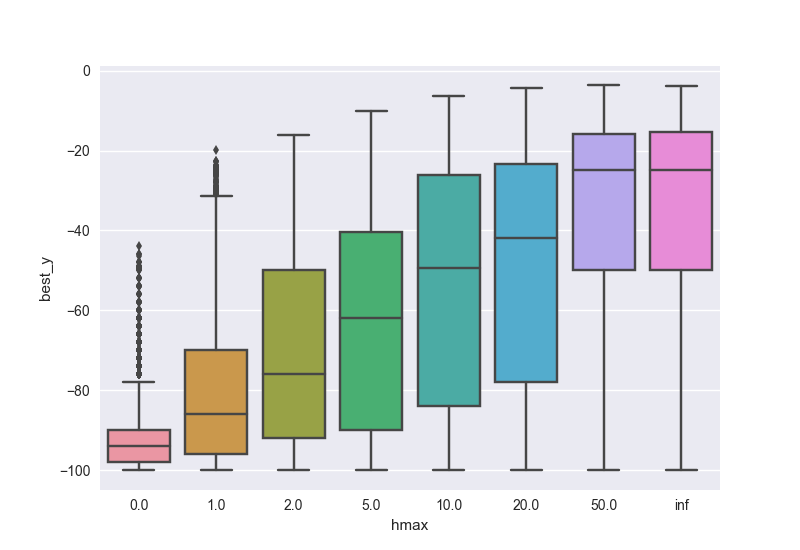

In [22]:
ax = sns.boxplot(x="hmax", y="best_y", data=table)

#### Number of evaluations (when successful), based on `hmax`?

Let's add another column, `success`:

In [23]:
table['success'] = table['neval'] < np.inf

In [24]:
table[table['success'] == True].head()

,heur,run,hmax,best_x,best_y,neval,success
3,SG_0,3,0.0,50,-100.0,5.0,True
9,SG_0,9,0.0,50,-100.0,85.0,True
23,SG_0,23,0.0,50,-100.0,17.0,True
29,SG_0,29,0.0,50,-100.0,22.0,True
40,SG_0,40,0.0,50,-100.0,74.0,True


Table:

In [25]:
table[table['success'] == True].groupby(['hmax'])['neval'].mean()

hmax
0.000000     49.593388
1.000000     50.512753
2.000000     50.479600
5.000000     48.781766
10.000000    49.033156
20.000000    49.796845
50.000000    53.113786
inf          54.694748
Name: neval, dtype: float64

In [26]:
table[table['success'] == True].groupby(['hmax'])['neval'].median()

hmax
0.000000     49.0
1.000000     50.0
2.000000     49.0
5.000000     48.0
10.000000    48.0
20.000000    49.0
50.000000    54.0
inf          56.0
Name: neval, dtype: float64

Chart:

<IPython.core.display.Javascript object>


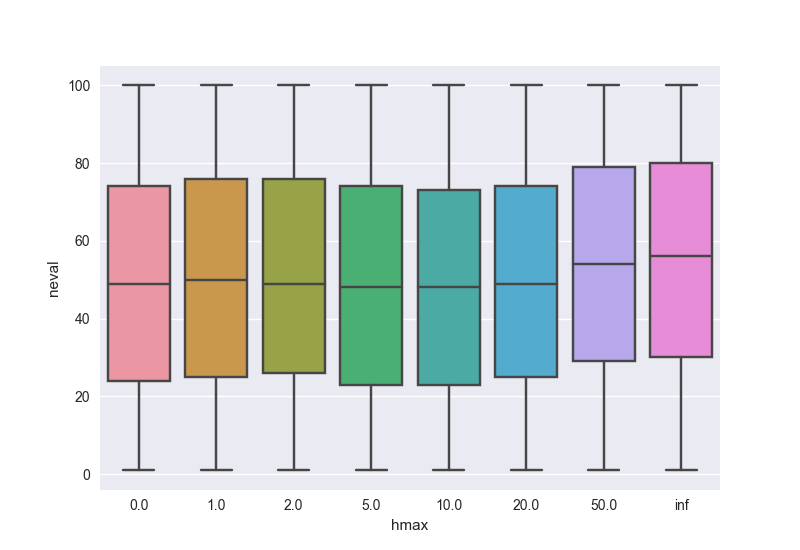

In [27]:
ax = sns.boxplot(x="hmax", y="neval", data=table[table['success'] == True])

#### Reliability

In [28]:
rel_by_hmax = table.pivot_table(
    index=['hmax'],
    values=['neval'],
    aggfunc=lambda x: len([n for n in x if n < np.inf])/len(x)
)

In [29]:
rel_by_hmax

,neval
hmax,
0.000000,0.1210
1.000000,0.1137
2.000000,0.1201
5.000000,0.1393
10.000000,0.1508
20.000000,0.1585
50.000000,0.1828
inf,0.1828


<IPython.core.display.Javascript object>


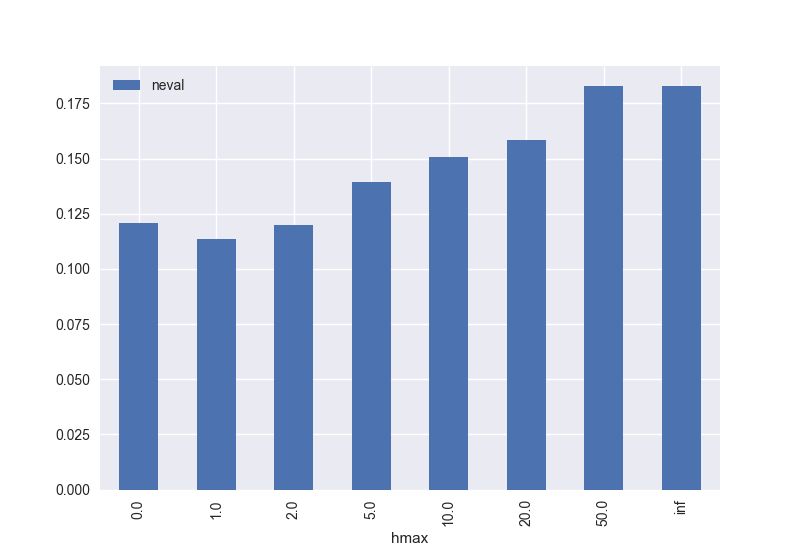

In [30]:
ax = rel_by_hmax.plot(kind='bar')

#### Speed, normalized by reliability?

* Reliability: $REL = m/q$ where $m$ is number of successful runs and $q$ is total number of runs, $REL \in [0, 1]$
* Mean Number of objective function Evaluations: $MNE = \frac{1}{m} \sum_{i=1}^m neval_i$
* Feoktistov criterion: $FEO = MNE/REL$

In [31]:
feo_by_hmax = table.pivot_table(
    index=['hmax'],
    values=['neval'],
    aggfunc=lambda x: np.mean([n for n in x if n < np.inf])/(len([n for n in x if n < np.inf])/len(x))
    #                 ^^^   mean number of evaluations ^^^ / ^^^             reliability         ^^^^
)

In [32]:
feo_by_hmax

,neval
hmax,
0.000000,409.862714
1.000000,444.263438
2.000000,420.313075
5.000000,350.192146
10.000000,325.153558
20.000000,314.175681
50.000000,290.556814
inf,299.205407


<IPython.core.display.Javascript object>


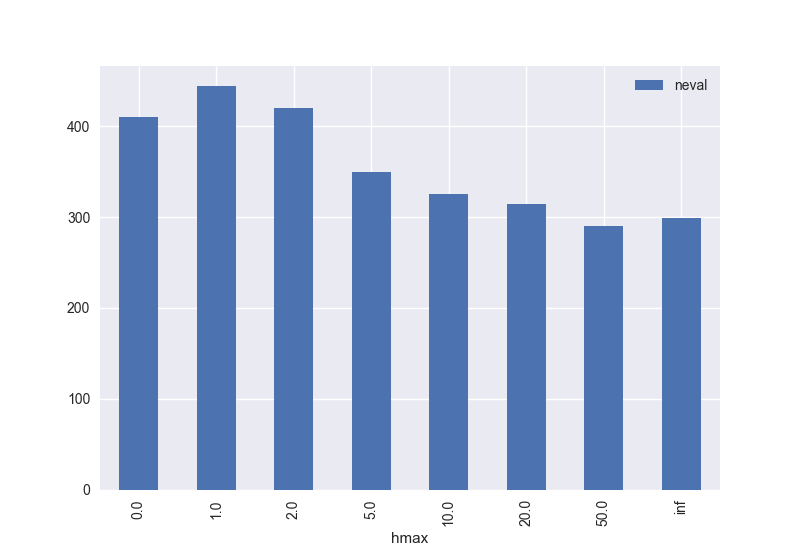

In [33]:
ax = feo_by_hmax.plot(kind='bar')

### `sum(x)` experiments

In [34]:
table = pd.DataFrame()
for hmax in [0, 1, 2, 5, 10, 20, 50, np.inf]:
    res = experiment(of_sum, 10000, hmax)
    table = pd.concat([table, res], axis=0)

#### Quality of solutions based on hmax?

<IPython.core.display.Javascript object>


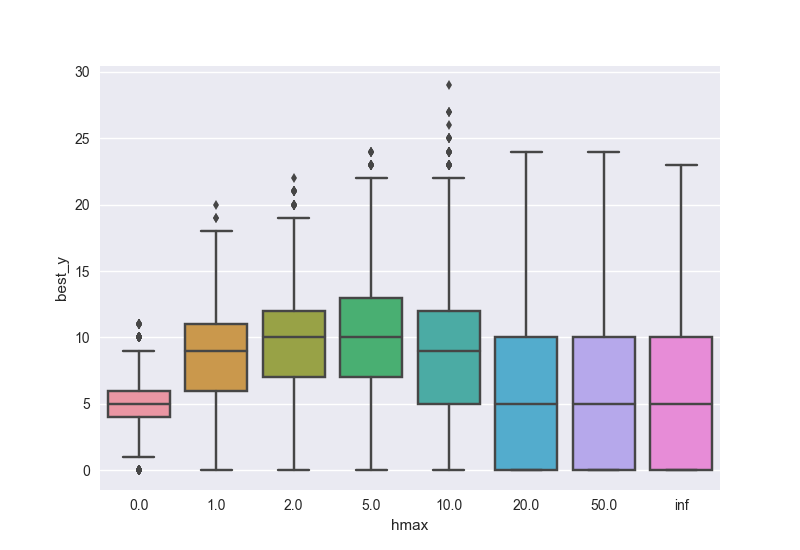

In [35]:
ax = sns.boxplot(x="hmax", y="best_y", data=table)

#### Number of evaluations (when successful), based on hmax?

In [36]:
table['success'] = table['neval'] < np.inf

<IPython.core.display.Javascript object>


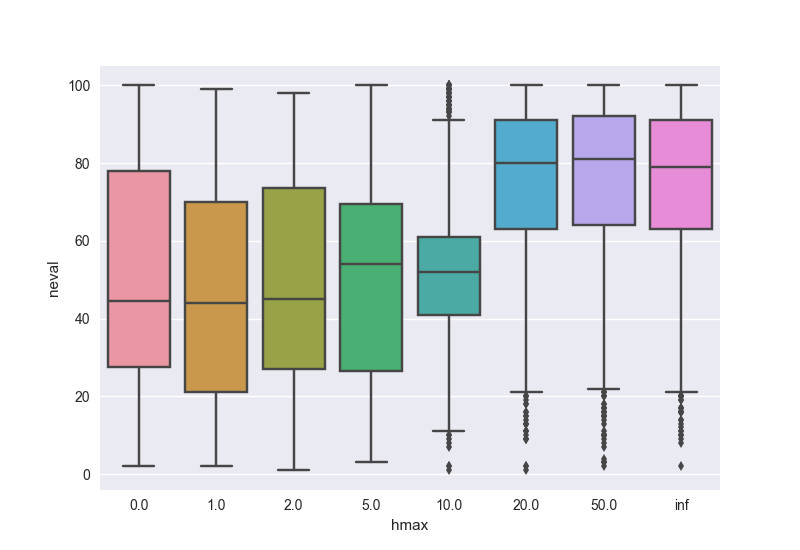

In [37]:
ax = sns.boxplot(x="hmax", y="neval", data=table[table['success'] == True])

#### Reliability?

In [38]:
rel_by_hmax = table.pivot_table(
    index=['hmax'],
    values=['neval'],
    aggfunc=lambda x: len([n for n in x if n < np.inf])/len(x)
)

In [39]:
rel_by_hmax

,neval
hmax,
0.000000,0.0054
1.000000,0.0043
2.000000,0.0071
5.000000,0.0211
10.000000,0.0793
20.000000,0.2820
50.000000,0.2873
inf,0.2877


<IPython.core.display.Javascript object>


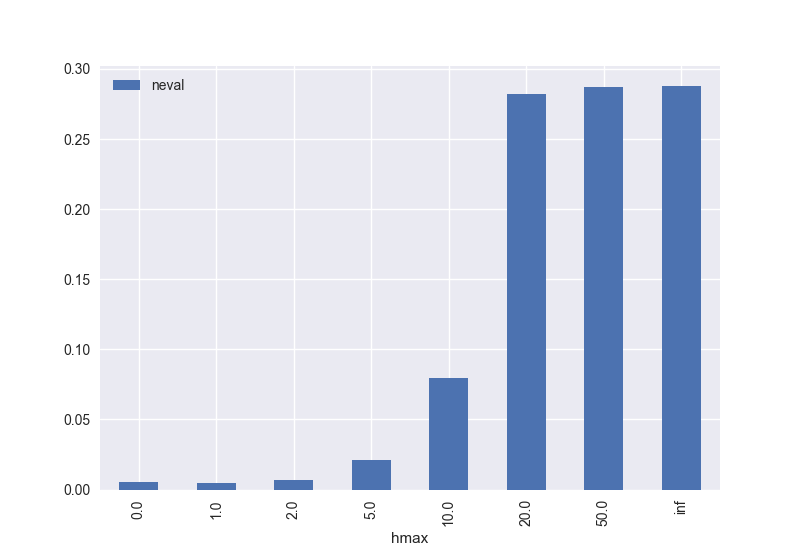

In [40]:
ax = rel_by_hmax.plot(kind='bar')

#### Feoktistov criterion?

In [41]:
feo_by_hmax = table.pivot_table(
    index=['hmax'],
    values=['neval'],
    aggfunc=lambda x: np.mean([n for n in x if n < np.inf])/(len([n for n in x if n < np.inf])/len(x))
)

<IPython.core.display.Javascript object>


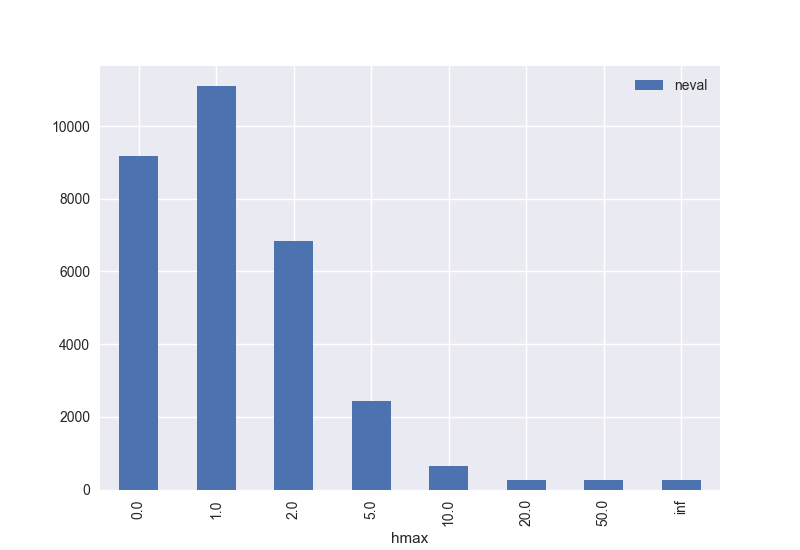

In [42]:
ax = feo_by_hmax.plot(kind='bar')

# Assignments (or rather inspiration for your own work)

1. Implement examples in this notebook on your own
1. Experiment with **neighbourhood diameter** `d` in `AirShip.get_neighborhood(x, d)`
1. Play with new heuristics in the existing framework and analyze their performance:
   1. **Random Descent**, similar to Shoot & Go, but does not follow steepest descent, chooses direction of the descent randomly instead
   1. **Taboo Search**